In [6]:
# ---------------------------------------------------------
# Asthma Meal Plan Evaluation Notebook
# Author: Kshitiz Sikriwal
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option("display.float_format", lambda x: f"{x:.2f}")
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["axes.grid"] = True

# Load dataset (auto first sheet)
DATA_PATH = Path("/Users/kshitizsikriwal/Kshitiz/evaluation/GPT/meal_to_yoga_top1_contrastive_Asthma.xlsx")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"❌ File not found: {DATA_PATH.resolve()}")

df = pd.read_excel(DATA_PATH, sheet_name=None)
sheet_name = list(df.keys())[0]
df = df[sheet_name]

print(f"✅ Loaded: {DATA_PATH.name} | Sheet: {sheet_name} | Shape: {df.shape}")
display(df.head(3))


✅ Loaded: meal_to_yoga_top1_contrastive_Asthma.xlsx | Sheet: Sheet1 | Shape: (42, 28)


,meal_index,meal_plan,meal_day,meal_time,meal_name,meal_description,Calories (kcal),Total_Fat (g),Protein (g),Carbohydrates (g),...,EPA + DHA (mg),Zinc (mg),yoga_index,yoga_plan,yoga_day,yoga_time,yoga_detailed,yoga_exercise,yoga_precautions,similarity
0,0,Plan A,Monday,Morning,Oatmeal with chia and berries,"Cooked oats with chia seeds and mixed berries,...",608.30,17.60,26.30,53.80,...,148.80,4.50,0,Plan A,Monday,Morning,"For Monday Morning, perform Sukhasana with dia...",Engage in 25–30 minutes of indoor brisk walkin...,Avoid exposure to dust or cold air. Ensure the...,0.12
1,1,Plan A,Monday,Afternoon,Grilled salmon with quinoa and spinach,"Salmon fillet with quinoa, spinach, and a sque...",530.90,18.50,27.30,79.50,...,133.30,3.50,12,Plan A,Friday,Morning,"For Friday Morning, perform Sukhasana with dia...",Engage in 25–30 minutes of indoor brisk walkin...,Avoid exposure to dust or cold air. Ensure the...,0.12
2,2,Plan A,Monday,Evening,Baked cod with roasted vegetables,"Oven-baked cod with roasted carrots, zucchini,...",553.90,22.70,38.50,66.00,...,174.80,3.70,2,Plan A,Monday,Evening,"For Monday Evening, perform Sukhasana with dia...",Engage in 25–30 minutes of indoor brisk walkin...,Avoid exposure to dust or cold air. Ensure the...,0.13


In [7]:
# ---------------------------------------------------------
# Normalize column names and detect plan/day columns
# ---------------------------------------------------------
def canon(text):
    if pd.isna(text): return text
    return "_".join(str(text).strip().lower().split())

df.columns = [canon(c) for c in df.columns]

plan_col = next((c for c in df.columns if "plan" in c), None)
day_col  = next((c for c in df.columns if "day" in c), None)
if not plan_col or not day_col:
    raise ValueError("❌ Could not auto-detect 'plan' or 'day' columns.")

df[plan_col] = df[plan_col].astype(str).apply(canon)
df[day_col]  = df[day_col].astype(str).apply(canon)

print(f"🧩 Plan column: {plan_col} | Day column: {day_col}")
print("Plans detected:", df[plan_col].unique())
print("Days detected:", df[day_col].unique())


🧩 Plan column: meal_plan | Day column: meal_day
Plans detected: ['plan_a' 'plan_b']
Days detected: ['monday' 'tuesday' 'wednesday' 'thursday' 'friday' 'saturday' 'sunday']


In [13]:
# ---------------------------------------------------------
# Robust nutrient mapping
# ---------------------------------------------------------
nutrient_patterns = {
    "Calories (kcal)"      : ["calorie","energy","kcal"],
    "Total Fat (g)"        : ["fat"],
    "Protein (g)"          : ["protein"],
    "Dietary Fiber (g)"    : ["fiber","fibre"],
    "Added Sugar (g)"      : ["sugar"],
    "Omega-3 (ALA) (g)"    : ["omega","ala"],
    "EPA+DHA (mg)"         : ["epa","dha"],
    "Selenium (ug)"        : ["selenium","se"],
    "Magnesium (mg)"       : ["magnesium","mg"],
    "Vitamin D (ug)"       : ["vitamin_d","vitd","vitamin d"],
}

matched = {}
for friendly, pats in nutrient_patterns.items():
    for p in pats:
        hit = next((col for col in df.columns if p in col), None)
        if hit:
            matched[friendly] = hit
            break

print("🧮 Mapped Nutrient Columns:")
for k,v in matched.items():
    print(f"  {k:22s} → {v}")

found_cols = list(matched.values())
for c in found_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")


🧮 Mapped Nutrient Columns:
  Calories (kcal)        → calories_(kcal)
  Total Fat (g)          → total_fat_(g)
  Protein (g)            → protein_(g)
  Dietary Fiber (g)      → dietary_fiber_(g)
  Added Sugar (g)        → added_sugar_(g)
  Omega-3 (ALA) (g)      → omega-3_(ala,_g)
  EPA+DHA (mg)           → epa_+_dha_(mg)
  Selenium (ug)          → selenium_(µg)
  Magnesium (mg)         → magnesium_(mg)
  Vitamin D (ug)         → vitamin_d_(µg)


In [14]:
# ---------------------------------------------------------
# Aggregate daily totals per plan → compute weekly averages
# ---------------------------------------------------------
daily_totals = (
    df.groupby([plan_col, day_col], as_index=False)[found_cols]
      .sum().sort_values([plan_col, day_col])
)
weekly_avg = daily_totals.groupby(plan_col)[found_cols].mean()

dataset_to_friendly = {v:k for k,v in matched.items()}

def make_series(plan_name):
    if plan_name not in weekly_avg.index:
        return pd.Series(dtype=float)
    return weekly_avg.loc[plan_name].rename(index=dataset_to_friendly)

weekly_avg_main = make_series("plan_a")
weekly_avg_alt  = make_series("plan_b")

print("✅ Weekly Averages Computed")
display(weekly_avg_main.round(2))
display(weekly_avg_alt.round(2))


✅ Weekly Averages Computed


Calories (kcal)     1919.44
Total Fat (g)         61.24
Protein (g)           92.30
Dietary Fiber (g)     34.61
Added Sugar (g)        5.07
Omega-3 (ALA) (g)      1.28
EPA+DHA (mg)         378.17
Selenium (ug)         59.56
Magnesium (mg)       379.21
Vitamin D (ug)         6.90
Name: plan_a, dtype: float64

Calories (kcal)     1836.11
Total Fat (g)         57.74
Protein (g)           87.99
Dietary Fiber (g)     34.49
Added Sugar (g)        7.11
Omega-3 (ALA) (g)      1.29
EPA+DHA (mg)         379.83
Selenium (ug)         56.67
Magnesium (mg)       363.49
Vitamin D (ug)         7.76
Name: plan_b, dtype: float64

In [15]:
# ---------------------------------------------------------
# Real-World Asthma Nutrition Reference Midpoints
# ---------------------------------------------------------
guideline_mid = pd.Series({
    "Calories (kcal)"   : 2000,
    "Total Fat (g)"     : (44 + 78) / 2,
    "Protein (g)"       : (56 + 175) / 2,   # 115.5 midpoint of AMDR range
    "Dietary Fiber (g)" : 28,
    "Added Sugar (g)"   : (25 + 50) / 2,    # 37.5 midpoint of <50 ideally ≤25
    "Omega-3 (ALA) (g)" : (1.1 + 1.6) / 2,  # 1.35
    "EPA+DHA (mg)"      : (250 + 500) / 2,  # 375
    "Selenium (ug)"     : 55,
    "Magnesium (mg)"    : (310 + 420) / 2,  # 365
    "Vitamin D (ug)"    : (5 + 15) / 2      # 10
}).dropna()

guideline_mid = guideline_mid.reindex(weekly_avg_main.index)
print("📘 Asthma Guideline Midpoints (Real-World Reference)")
display(guideline_mid.round(2))


📘 Asthma Guideline Midpoints (Real-World Reference)


Calories (kcal)     2000.00
Total Fat (g)         61.00
Protein (g)          115.50
Dietary Fiber (g)     28.00
Added Sugar (g)       37.50
Omega-3 (ALA) (g)      1.35
EPA+DHA (mg)         375.00
Selenium (ug)         55.00
Magnesium (mg)       365.00
Vitamin D (ug)        10.00
dtype: float64

In [16]:
# ---------------------------------------------------------
# Compute MAE, MSE, RMSE per plan vs guideline
# ---------------------------------------------------------
def compute_errors(pred, real):
    df_err = pd.DataFrame({"Predicted": pred, "Guideline": real})
    df_err["Absolute Error"] = (df_err["Predicted"] - df_err["Guideline"]).abs()
    df_err["Percentage Error (%)"] = (df_err["Absolute Error"] / df_err["Guideline"]) * 100
    mae = df_err["Absolute Error"].mean()
    mse = (df_err["Absolute Error"] ** 2).mean()
    rmse = np.sqrt(mse)
    metrics = pd.Series({"MAE": mae, "MSE": mse, "RMSE": rmse}).round(3)
    return df_err.round(2), metrics

main_errors, main_metrics = compute_errors(weekly_avg_main, guideline_mid)
alt_errors,  alt_metrics  = compute_errors(weekly_avg_alt,  guideline_mid)

print("📈 Asthma — Plan A (Main) Errors")
display(main_errors)
display(main_metrics)

print("\n📈 Asthma — Plan B (Alternate) Errors")
display(alt_errors)
display(alt_metrics)


📈 Asthma — Plan A (Main) Errors


,Predicted,Guideline,Absolute Error,Percentage Error (%)
Calories (kcal),1919.44,2000.00,80.56,4.03
Total Fat (g),61.24,61.00,0.24,0.40
Protein (g),92.30,115.50,23.20,20.09
Dietary Fiber (g),34.61,28.00,6.61,23.62
Added Sugar (g),5.07,37.50,32.43,86.48
Omega-3 (ALA) (g),1.28,1.35,0.07,4.87
EPA+DHA (mg),378.17,375.00,3.17,0.85
Selenium (ug),59.56,55.00,4.56,8.29
Magnesium (mg),379.21,365.00,14.21,3.89
Vitamin D (ug),6.90,10.00,3.10,31.00


MAE     16.82
MSE    836.56
RMSE    28.92
dtype: float64


📈 Asthma — Plan B (Alternate) Errors


,Predicted,Guideline,Absolute Error,Percentage Error (%)
Calories (kcal),1836.11,2000.00,163.89,8.19
Total Fat (g),57.74,61.00,3.26,5.34
Protein (g),87.99,115.50,27.51,23.82
Dietary Fiber (g),34.49,28.00,6.49,23.16
Added Sugar (g),7.11,37.50,30.39,81.03
Omega-3 (ALA) (g),1.29,1.35,0.06,4.66
EPA+DHA (mg),379.83,375.00,4.83,1.29
Selenium (ug),56.67,55.00,1.67,3.04
Magnesium (mg),363.49,365.00,1.51,0.41
Vitamin D (ug),7.76,10.00,2.24,22.43


MAE      24.18
MSE    2862.50
RMSE     53.50
dtype: float64

,Guideline (Midpoint),Predicted (Plan A),Predicted (Plan B),Z-Score (Plan A),Z-Score (Plan B)
Calories (kcal),2000.00,1919.44,1836.11,-0.14,-0.28
Total Fat (g),61.00,61.24,57.74,0.00,-0.01
Protein (g),115.50,92.30,87.99,-0.04,-0.05
Dietary Fiber (g),28.00,34.61,34.49,0.01,0.01
Added Sugar (g),37.50,5.07,7.11,-0.06,-0.05
Omega-3 (ALA) (g),1.35,1.28,1.29,-0.00,-0.00
EPA+DHA (mg),375.00,378.17,379.83,0.01,0.01
Selenium (ug),55.00,59.56,56.67,0.01,0.00
Magnesium (mg),365.00,379.21,363.49,0.02,-0.00
Vitamin D (ug),10.00,6.90,7.76,-0.01,-0.00


🔹 Avg |Z| (Plan A) = 0.029
🔹 Avg |Z| (Plan B) = 0.042


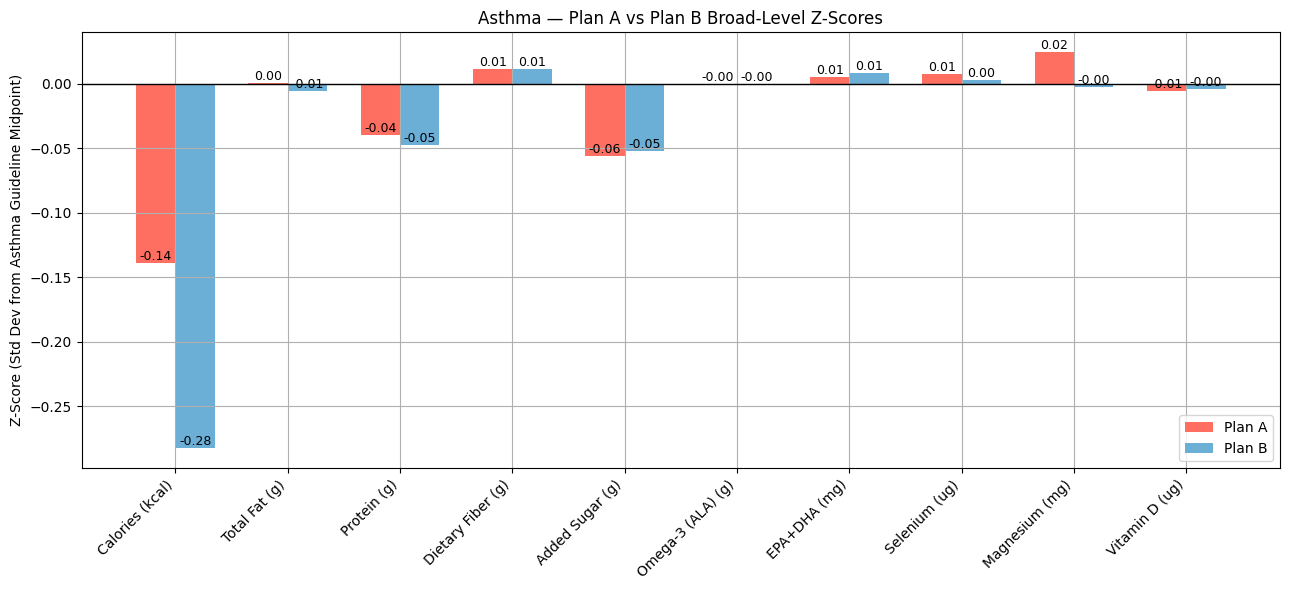

In [17]:
# ---------------------------------------------------------
# Compute broad-level Z-scores (standard deviation from guideline)
# ---------------------------------------------------------
guideline_std = np.std(guideline_mid.values, ddof=0)

z_main = (weekly_avg_main.values - guideline_mid.values) / guideline_std
z_alt  = (weekly_avg_alt.values  - guideline_mid.values) / guideline_std

z_main_series = pd.Series(z_main, index=guideline_mid.index, name="Z-Score (Plan A)")
z_alt_series  = pd.Series(z_alt,  index=guideline_mid.index, name="Z-Score (Plan B)")

z_df = pd.DataFrame({
    "Guideline (Midpoint)": guideline_mid,
    "Predicted (Plan A)": weekly_avg_main,
    "Predicted (Plan B)": weekly_avg_alt,
    "Z-Score (Plan A)": z_main_series,
    "Z-Score (Plan B)": z_alt_series
}).round(3)

display(z_df)

avg_abs_z_main = np.abs(z_main_series).mean()
avg_abs_z_alt  = np.abs(z_alt_series).mean()
print(f"🔹 Avg |Z| (Plan A) = {avg_abs_z_main:.3f}")
print(f"🔹 Avg |Z| (Plan B) = {avg_abs_z_alt:.3f}")

# Annotated bar plot
x = np.arange(len(z_df.index))
bar_width = 0.35
fig, ax = plt.subplots(figsize=(13,6))
bars1 = ax.bar(x - bar_width/2, z_main_series, width=bar_width, label="Plan A", color="#FF6F61")
bars2 = ax.bar(x + bar_width/2, z_alt_series,  width=bar_width, label="Plan B", color="#6BAED6")

for bars in [bars1, bars2]:
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h, f"{h:.2f}", ha='center', va='bottom', fontsize=9)

ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(z_df.index, rotation=45, ha='right')
ax.set_ylabel("Z-Score (Std Dev from Asthma Guideline Midpoint)")
ax.set_title("Asthma — Plan A vs Plan B Broad-Level Z-Scores")
ax.legend()
plt.tight_layout()
plt.show()
